In [37]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 10

# Завантаження даних

In [38]:
dim_airport = pd.read_csv('../output/Dim_Airport.csv')
dim_marketing_airline = pd.read_csv('../output/Dim_Marketing_Airline.csv')
dim_operating_airline = pd.read_csv('../output/Dim_Operating_Airline.csv')
dim_date = pd.read_csv('../output/Dim_Date.csv')
dim_time = pd.read_csv('../output/Dim_Time.csv')
fact_flight = pd.read_csv('../output/FactFlight.csv')

print(f"Dim_Airport: {len(dim_airport)} записів")
print(f"Dim_Marketing_Airline: {len(dim_marketing_airline)} записів")
print(f"Dim_Operating_Airline: {len(dim_operating_airline)} записів")
print(f"Dim_Date: {len(dim_date)} записів")
print(f"Dim_Time: {len(dim_time)} записів")
print(f"FactFlight: {len(fact_flight):,} записів")


Dim_Airport: 389 записів
Dim_Marketing_Airline: 11 записів
Dim_Operating_Airline: 28 записів
Dim_Date: 1673 записів
Dim_Time: 1305 записів
FactFlight: 29,204,363 записів


# 1. Статистика по категоріях

## Топ-10 найбільш завантажених аеропортів

Топ-10 найбільш завантажених аеропортів:
airport_code             city_name   count
         ORD           Chicago, IL 2750199
         ATL           Atlanta, GA 2743585
         DEN            Denver, CO 2341182
         DFW Dallas/Fort Worth, TX 2208448
         CLT         Charlotte, NC 1815610
         LAX       Los Angeles, CA 1702544
         SEA           Seattle, WA 1450649
         IAH           Houston, TX 1378802
         PHX           Phoenix, AZ 1354250
         LAS         Las Vegas, NV 1332419


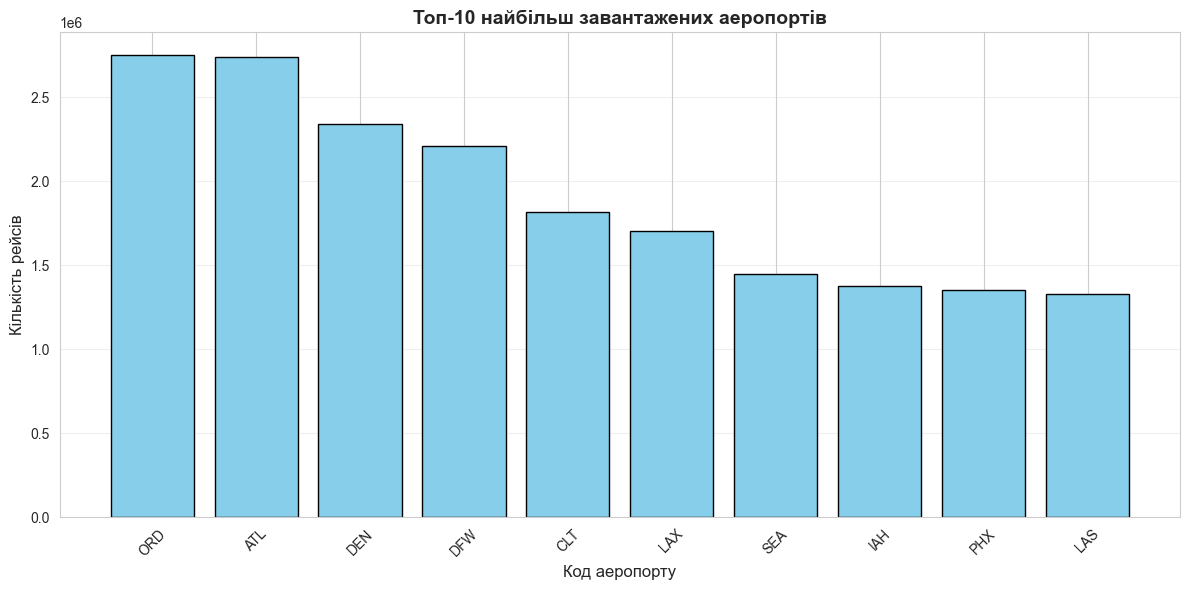

In [52]:
origin_counts = fact_flight.groupby('origin_airport_id').size().reset_index(name='count')
dest_counts = fact_flight.groupby('destination_airport_id').size().reset_index(name='count')

origin_counts.columns = ['airport_id', 'count']
dest_counts.columns = ['airport_id', 'count']

airport_traffic = pd.concat([origin_counts, dest_counts]).groupby('airport_id')['count'].sum().reset_index()

airport_traffic = airport_traffic.merge(dim_airport, on='airport_id', how='left')

top_airports = airport_traffic.nlargest(10, 'count')

print("Топ-10 найбільш завантажених аеропортів:")
print(top_airports[['airport_code', 'city_name', 'count']].to_string(index=False))

plt.figure(figsize=(12, 6))
plt.bar(top_airports['airport_code'], top_airports['count'], color='skyblue', edgecolor='black')
plt.xlabel('Код аеропорту', fontsize=12)
plt.ylabel('Кількість рейсів', fontsize=12)
plt.title('Топ-10 найбільш завантажених аеропортів', fontsize=14, fontweight='bold')
plt.xticks(rotation=45)
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()


## Топ-10 авіакомпаній по кількості рейсів (Operating)

Топ-10 авіакомпаній по кількості рейсів:
iata_code           airline_name  flights_count
       WN Southwest Airlines Co.        5474339
       DL   Delta Air Lines Inc.        3294917
       OO  SkyWest Airlines Inc.        3159683
       AA American Airlines Inc.        3134117
       UA  United Air Lines Inc.        2354538
       YX      Republic Airlines        1283704
       B6        JetBlue Airways        1106079
       MQ              Envoy Air        1072778
       9E      Endeavor Air Inc.         998224
       OH            Comair Inc.         957220


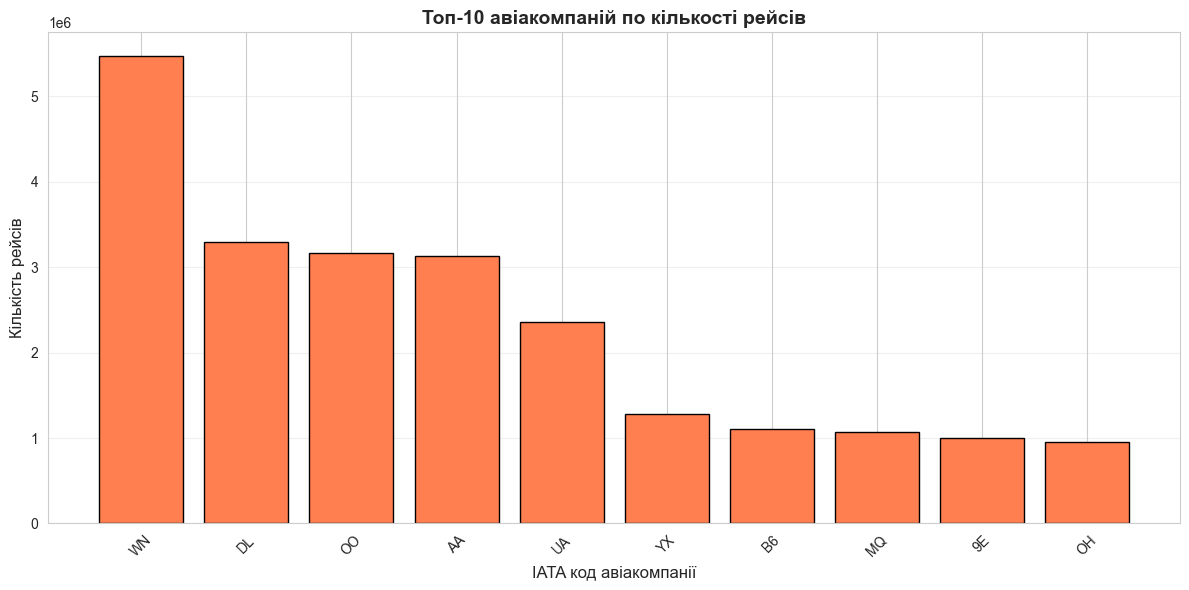

In [53]:
airline_counts = fact_flight.groupby('operating_airline_id').size().reset_index(name='flights_count')

airline_counts = airline_counts.merge(dim_operating_airline, on='operating_airline_id', how='left')

top_airlines = airline_counts.nlargest(10, 'flights_count')

print("Топ-10 авіакомпаній по кількості рейсів:")
print(top_airlines[['iata_code', 'airline_name', 'flights_count']].to_string(index=False))

plt.figure(figsize=(12, 6))
plt.bar(top_airlines['iata_code'], top_airlines['flights_count'], color='coral', edgecolor='black')
plt.xlabel('IATA код авіакомпанії', fontsize=12)
plt.ylabel('Кількість рейсів', fontsize=12)
plt.title('Топ-10 авіакомпаній по кількості рейсів', fontsize=14, fontweight='bold')
plt.xticks(rotation=45)
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()


## Топ-10 найпопулярніших маршрутів

Топ-10 найпопулярніших маршрутів:
                                          route  flights_count
SFO (San Francisco, CA) → LAX (Los Angeles, CA)          56204
LAX (Los Angeles, CA) → SFO (San Francisco, CA)          56194
    LAX (Los Angeles, CA) → LAS (Las Vegas, NV)          44668
    LAS (Las Vegas, NV) → LAX (Los Angeles, CA)          44575
         ORD (Chicago, IL) → LGA (New York, NY)          44364
         LGA (New York, NY) → ORD (Chicago, IL)          44338
         HNL (Honolulu, HI) → OGG (Kahului, HI)          40725
         OGG (Kahului, HI) → HNL (Honolulu, HI)          40722
     LAX (Los Angeles, CA) → JFK (New York, NY)          40381
     JFK (New York, NY) → LAX (Los Angeles, CA)          40315


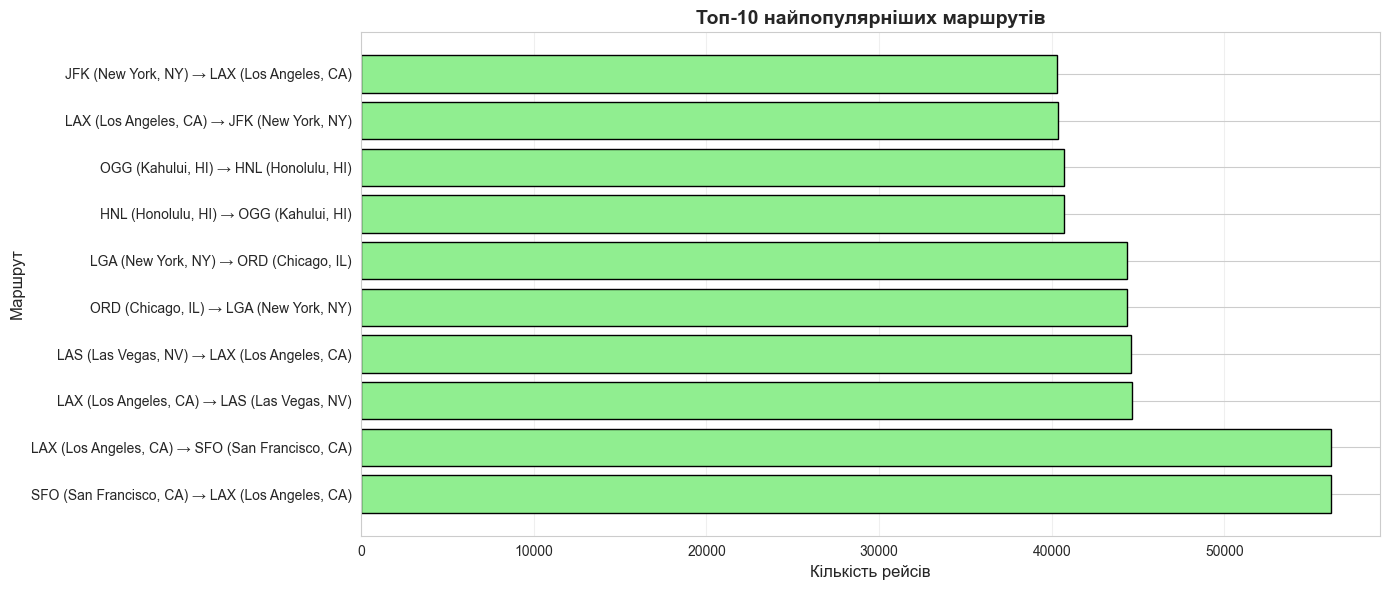

In [63]:
routes = fact_flight.groupby(['origin_airport_id', 'destination_airport_id']).size().reset_index(name='flights_count')

routes = routes.merge(dim_airport[['airport_id', 'airport_code', 'city_name']],
                      left_on='origin_airport_id',
                      right_on='airport_id',
                      how='left').rename(columns={'airport_code': 'origin_code', 'city_name': 'origin_city'})

routes = routes.merge(dim_airport[['airport_id', 'airport_code', 'city_name']],
                      left_on='destination_airport_id',
                      right_on='airport_id',
                      how='left').rename(columns={'airport_code': 'dest_code', 'city_name': 'dest_city'})

routes['route'] = routes['origin_code'] + ' (' + routes['origin_city'] + ') → ' + routes['dest_code'] + ' (' + routes['dest_city'] + ')'

top_routes = routes.nlargest(10, 'flights_count')

print("Топ-10 найпопулярніших маршрутів:")
print(top_routes[['route', 'flights_count']].to_string(index=False))

plt.figure(figsize=(14, 6))
plt.barh(range(len(top_routes)), top_routes['flights_count'], color='lightgreen', edgecolor='black')
plt.yticks(range(len(top_routes)), top_routes['route'])
plt.xlabel('Кількість рейсів', fontsize=12)
plt.ylabel('Маршрут', fontsize=12)
plt.title('Топ-10 найпопулярніших маршрутів', fontsize=14, fontweight='bold')
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()

## Розподіл по штатах

Топ-15 штатів по кількості вильотів:
    state_name  flights_count
    California        3085148
         Texas        3038086
       Florida        2355199
      Illinois        1790511
       Georgia        1479353
      New York        1340734
      Colorado        1319644
North Carolina        1310509
      Virginia        1083884
    Washington         880907
       Arizona         792722
  Pennsylvania         776277
      Michigan         769009
        Nevada         756720
    New Jersey         601718


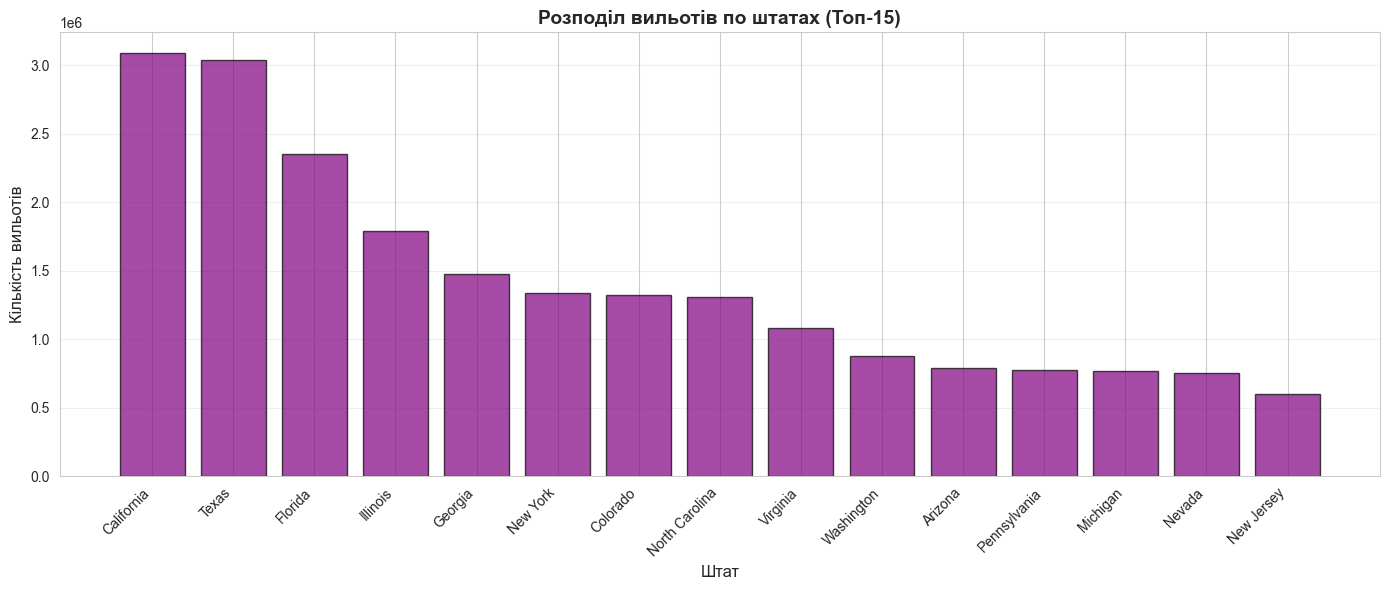

In [55]:
state_flights = fact_flight.merge(dim_airport[['airport_id', 'state_name']],
                                   left_on='origin_airport_id',
                                   right_on='airport_id',
                                   how='left')

state_distribution = state_flights.groupby('state_name').size().reset_index(name='flights_count')
top_states = state_distribution.nlargest(15, 'flights_count')

print("Топ-15 штатів по кількості вильотів:")
print(top_states.to_string(index=False))

plt.figure(figsize=(14, 6))
plt.bar(top_states['state_name'], top_states['flights_count'], color='purple', alpha=0.7, edgecolor='black')
plt.xlabel('Штат', fontsize=12)
plt.ylabel('Кількість вильотів', fontsize=12)
plt.title('Розподіл вильотів по штатах (Топ-15)', fontsize=14, fontweight='bold')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

# 2. Темпоральна статистика

## Кількість рейсів по місяцях

Кількість рейсів по місяцях:
 month  flights_count
     1        2700828
     2        2345133
     3        2795333
     4        2537619
     5        2360842
     6        2426376
     7        2691371
     8        2231851
     9        2212084
    10        2333721
    11        2261108
    12        2308097


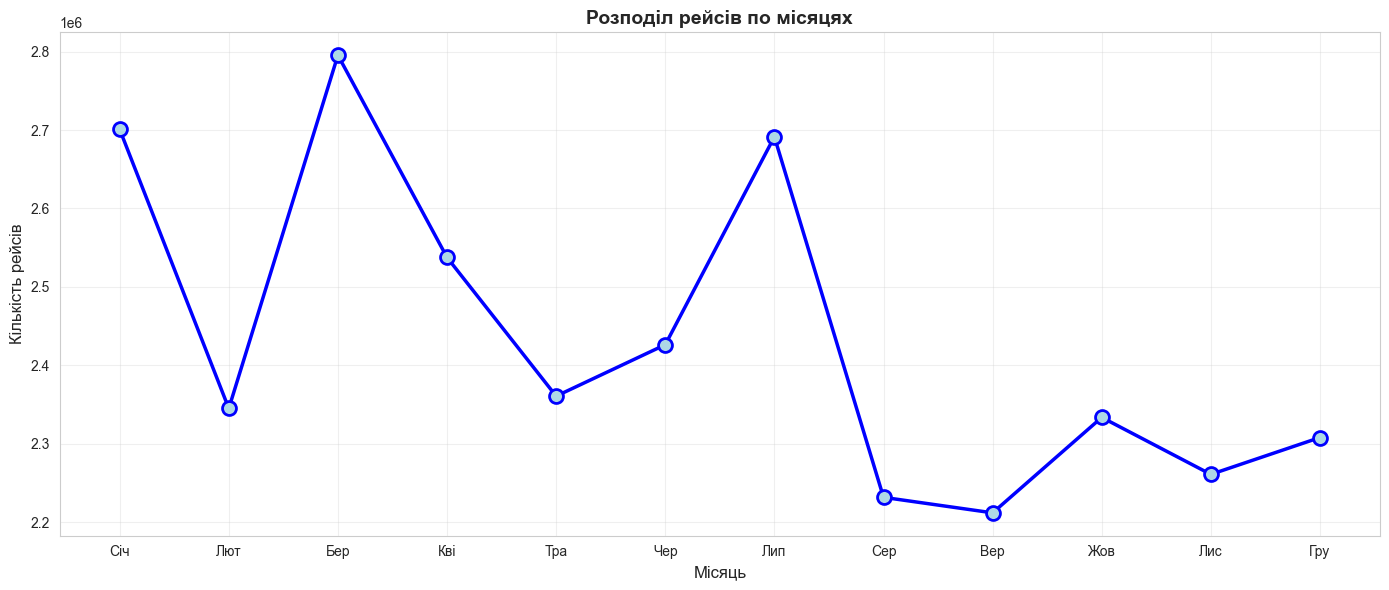

In [56]:
flights_with_date = fact_flight.merge(dim_date, on='date_id', how='left')

flights_by_month = flights_with_date.groupby('month').size().reset_index(name='flights_count')
flights_by_month = flights_by_month.sort_values('month')

print("Кількість рейсів по місяцях:")
print(flights_by_month.to_string(index=False))

months_uk = ['Січ', 'Лют', 'Бер', 'Кві', 'Тра', 'Чер',
             'Лип', 'Сер', 'Вер', 'Жов', 'Лис', 'Гру']

plt.figure(figsize=(14, 6))
plt.plot(flights_by_month['month'], flights_by_month['flights_count'],
         marker='o', linewidth=2.5, markersize=10, color='blue', markerfacecolor='lightblue', markeredgewidth=2)
plt.xlabel('Місяць', fontsize=12)
plt.ylabel('Кількість рейсів', fontsize=12)
plt.title('Розподіл рейсів по місяцях', fontsize=14, fontweight='bold')
plt.xticks(range(1, 13), months_uk)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


## Кількість рейсів по днях тижня

Кількість рейсів по днях тижня:
 day_of_week  flights_count
           1        4358940
           2        4050572
           3        4125121
           4        4334474
           5        4355759
           6        3723782
           7        4255715


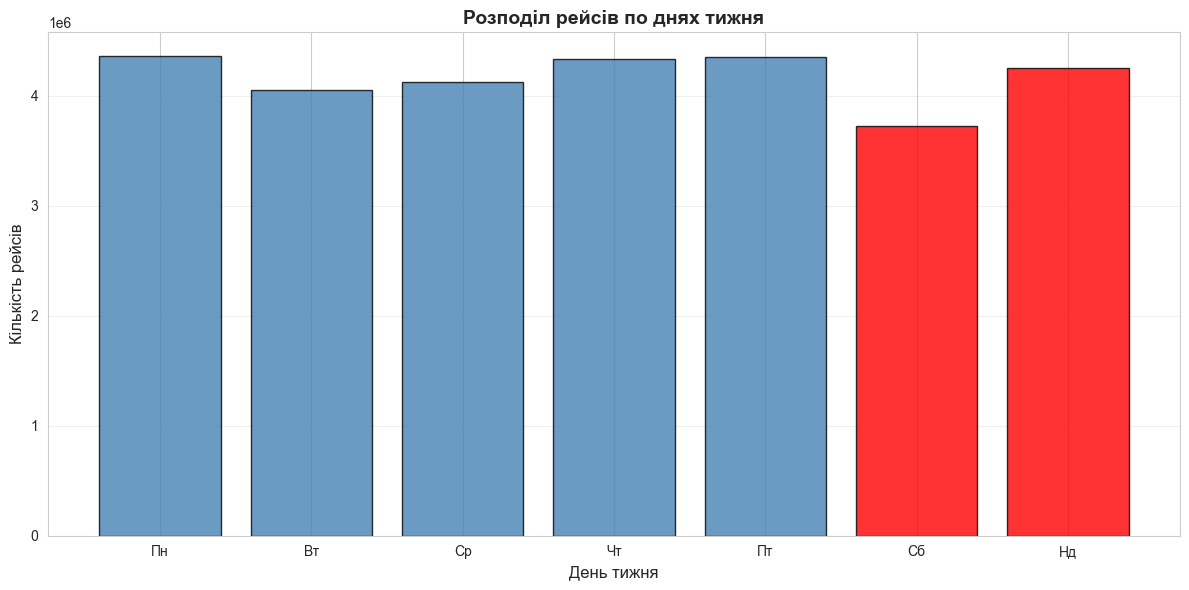

In [57]:
flights_with_date = fact_flight.merge(dim_date, on='date_id', how='left')

flights_with_date['flight_date'] = pd.to_datetime(flights_with_date['flight_date'])

flights_with_date['day_of_week'] = flights_with_date['flight_date'].dt.dayofweek + 1

flights_by_dow = flights_with_date.groupby('day_of_week').size().reset_index(name='flights_count')
flights_by_dow = flights_by_dow.sort_values('day_of_week')

print("Кількість рейсів по днях тижня:")
print(flights_by_dow.to_string(index=False))

days_uk = ['Пн', 'Вт', 'Ср', 'Чт', 'Пт', 'Сб', 'Нд']
colors = ['steelblue' if x < 6 else 'red' for x in flights_by_dow['day_of_week']]

plt.figure(figsize=(12, 6))
plt.bar(flights_by_dow['day_of_week'], flights_by_dow['flights_count'],
        color=colors, edgecolor='black', alpha=0.8)
plt.xlabel('День тижня', fontsize=12)
plt.ylabel('Кількість рейсів', fontsize=12)
plt.title('Розподіл рейсів по днях тижня', fontsize=14, fontweight='bold')
plt.xticks(flights_by_dow['day_of_week'], days_uk)
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

## Кількість рейсів по кварталах

Кількість рейсів по кварталах:
 quarter  flights_count
       1        7841294
       2        7324837
       3        7135306
       4        6902926


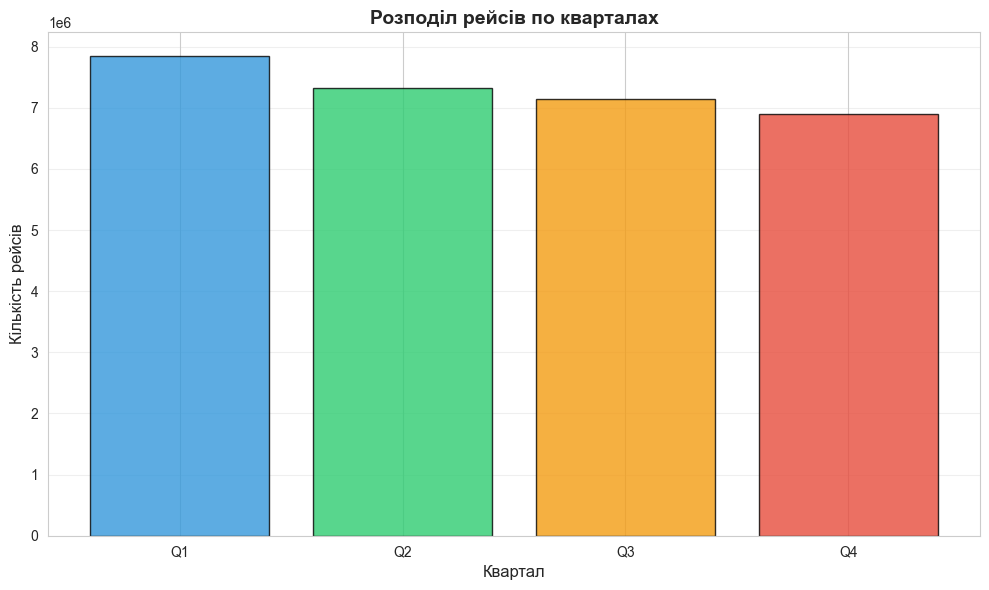

In [64]:
flights_by_quarter = flights_with_date.groupby('quarter').size().reset_index(name='flights_count')
flights_by_quarter = flights_by_quarter.sort_values('quarter')

print("Кількість рейсів по кварталах:")
print(flights_by_quarter.to_string(index=False))

plt.figure(figsize=(10, 6))
colors_q = ['#3498db', '#2ecc71', '#f39c12', '#e74c3c']
plt.bar(flights_by_quarter['quarter'], flights_by_quarter['flights_count'],
        color=colors_q, edgecolor='black', alpha=0.8)
plt.xlabel('Квартал', fontsize=12)
plt.ylabel('Кількість рейсів', fontsize=12)
plt.title('Розподіл рейсів по кварталах', fontsize=14, fontweight='bold')
plt.xticks([1, 2, 3, 4], ['Q1', 'Q2', 'Q3', 'Q4'])
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()


## Сезонність (літо vs зима)

Розподіл рейсів по сезонах:
season  flights_count
  Інше       14500707
  Зима        7354058
  Літо        7349598


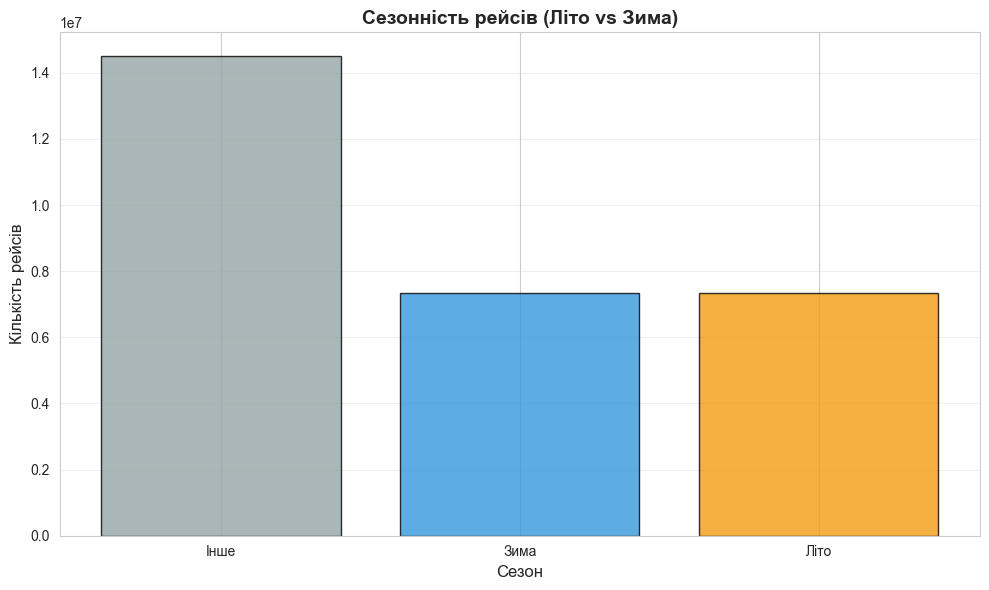

In [65]:
flights_with_date['season'] = flights_with_date['month'].apply(
    lambda x: 'Літо' if x in [6, 7, 8] else ('Зима' if x in [12, 1, 2] else 'Інше')
)

season_stats = flights_with_date.groupby('season').size().reset_index(name='flights_count')

print("Розподіл рейсів по сезонах:")
print(season_stats.to_string(index=False))

plt.figure(figsize=(10, 6))
colors_season = {'Літо': '#f39c12', 'Зима': '#3498db', 'Інше': '#95a5a6'}
plt.bar(season_stats['season'], season_stats['flights_count'],
        color=[colors_season[s] for s in season_stats['season']],
        edgecolor='black', alpha=0.8)
plt.xlabel('Сезон', fontsize=12)
plt.ylabel('Кількість рейсів', fontsize=12)
plt.title('Сезонність рейсів (Літо vs Зима)', fontsize=14, fontweight='bold')
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

# 3. Розподіл по часу доби

## Розподіл по годинах вильоту

Кількість рейсів по годинах:
 hour  flights_count
  1.0           1228
  2.0            374
  3.0            176
  4.0            101
  5.0           5886
  6.0          54273
  7.0          48079
  8.0          35885
  9.0          32561
 10.0        1779388


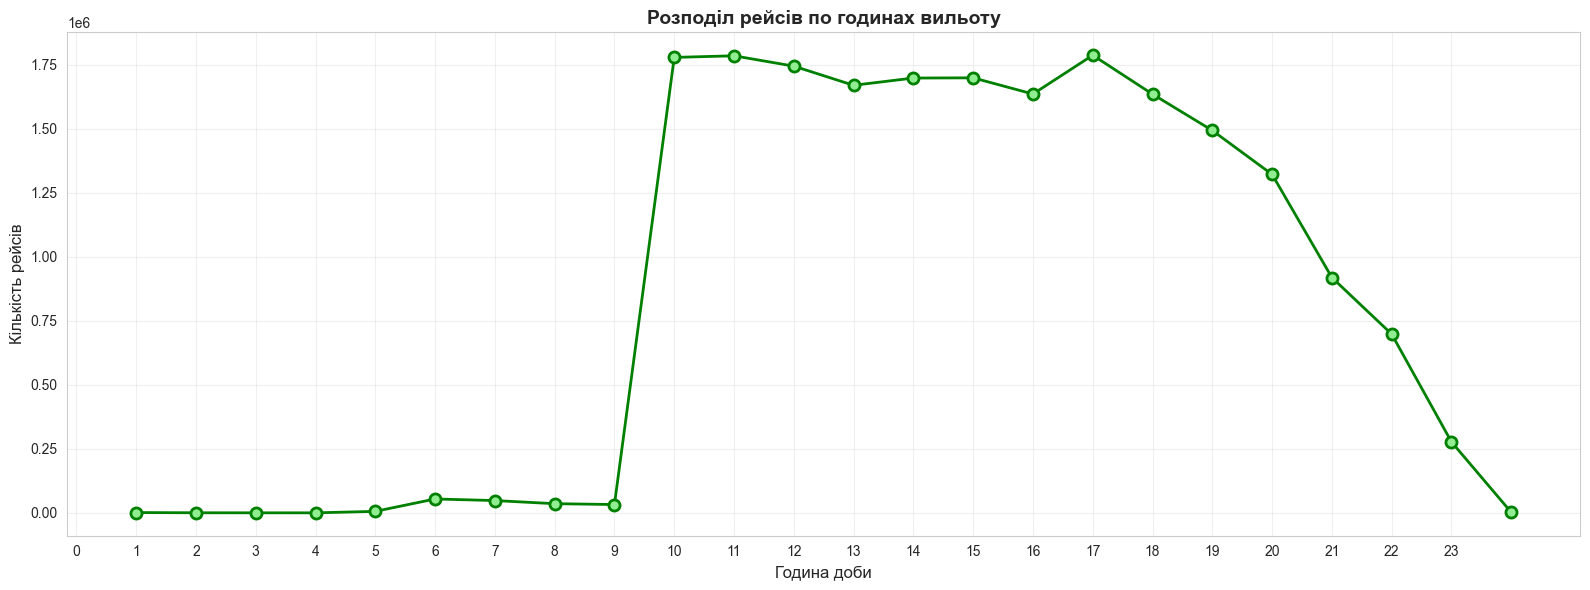

In [66]:
flights_with_time = fact_flight.merge(dim_time, left_on='departure_time_id', right_on='time_id', how='left')

flights_by_hour = flights_with_time.groupby('hour').size().reset_index(name='flights_count')
flights_by_hour = flights_by_hour.sort_values('hour')

print("Кількість рейсів по годинах:")
print(flights_by_hour.head(10).to_string(index=False))

plt.figure(figsize=(16, 6))
plt.plot(flights_by_hour['hour'], flights_by_hour['flights_count'],
         marker='o', linewidth=2, markersize=8, color='green', markerfacecolor='lightgreen', markeredgewidth=2)
plt.xlabel('Година доби', fontsize=12)
plt.ylabel('Кількість рейсів', fontsize=12)
plt.title('Розподіл рейсів по годинах вильоту', fontsize=14, fontweight='bold')
plt.xticks(range(0, 24))
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## Пікові години вильотів (Топ-5)

Топ-5 пікових годин вильотів:
 hour  flights_count
 17.0        1787926
 11.0        1785645
 10.0        1779388
 12.0        1745221
 15.0        1699535


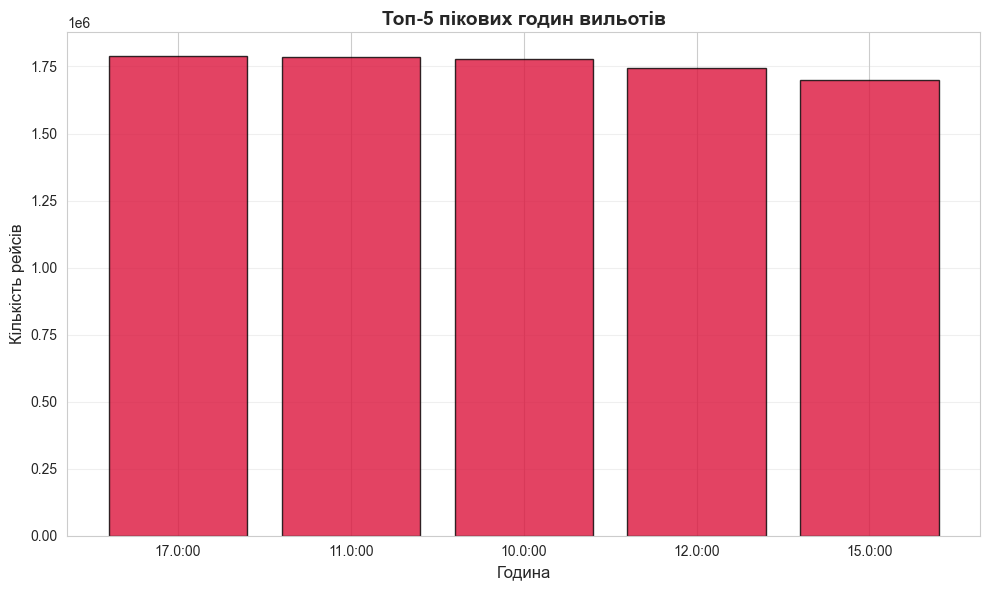

In [67]:
top_hours = flights_by_hour.nlargest(5, 'flights_count')

print("Топ-5 пікових годин вильотів:")
print(top_hours.to_string(index=False))

plt.figure(figsize=(10, 6))
plt.bar(top_hours['hour'].astype(str) + ':00', top_hours['flights_count'],
        color='crimson', edgecolor='black', alpha=0.8)
plt.xlabel('Година', fontsize=12)
plt.ylabel('Кількість рейсів', fontsize=12)
plt.title('Топ-5 пікових годин вильотів', fontsize=14, fontweight='bold')
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()


# Загальні висновки аналізу авіаперевезень

### Географічна концентрація
- Авіаційний трафік США сконцентрований у трьох основних штатах: **Каліфорнія** (3.1М рейсів), **Техас** (3.0М) та **Флорида** (2.4М), які разом забезпечують понад **30% всіх вильотів**. Найзавантаженіші аеропорти (**ORD** - 2.75М, **ATL** - 2.74М, **DEN** - 2.34М) є основними хабами.

### Домінування маршрутів
- Топ-10 маршрутів демонструють чітку закономірність: найпопулярніші напрямки є **двосторонніми** (SFO↔LAX - 56.2К у кожному напрямку, LAX↔LAS - 44.6К, ORD↔LGA - 44.4К), що свідчить про стабільний попит у обох напрямках. Міжконтинентальні маршрути **Схід-Захід** (LAX-JFK - 40.4К) та **внутрішньогавайські** рейси (HNL↔OGG - 40.7К) також входять до топу.

### Ринкова структура
- **Southwest Airlines** лідирує з **5.5М рейсів** (майже вдвічі більше за Delta - 3.3М), демонструючи домінування **лоукост-моделі**. Топ-3 авіакомпанії (WN, DL, OO) забезпечують близько **40% усього ринку**.

### Часові закономірності

#### Сезонність
- **Березень** (2.8М) та **липень** (2.7М) є піковими місяцями, тоді як **вересень** показує найнижчі показники (**2.2М**). **Перший квартал** є найактивнішим (**7.8М** рейсів), четвертий - найменш активним (**6.9М**).

#### Тижневі тренди
- **Робочі дні** мають стабільно високий трафік: **понеділок** та **п'ятниця** - по **4.4М** рейсів, **субота** показує найбільший спад до **3.7М**, **неділя** повертається до **4.3М**.

#### Денна динаміка
- Пік припадає на **17:00** (**1.79М** рейсів), **11:00** (**1.79М**) та **10:00** (**1.78М**). **Нічні рейси** (1:00-5:00) становлять менше **8 тисяч** рейсів сумарно.